## Loss prediction for Active Learning for DETR TB Bacilli Detection

This notebook is used to predict the loss of our trained DETR model for the next iteration of active learning.

The loss is predicted using a Neural Network that takes as input the features of the current model from different modules of the DETR model and outputs the (predicted) loss.

We make experiments with different combinations of features and also include other ML loss-prediction models (e.g. Random Forest, Linear Regression) for comparison.

Advantages of predicting the loss of the model for active learning:

- The loss of a NN encodes information about the model's performance on the training data. Therefore, the loss can be used as a proxy for the model's performance on the test data. This is useful for active learning since we want to select the images that will improve the model's performance on the test data.
- We can predict the loss of the model for the next iteration of active learning and select the images with the highest loss for annotation.
- While the learned loss-prediction model is model-specific, the same method can be used for any DNN-based architecture (e.g. Faster R-CNN, YOLO, etc.) since they are all based in computing the loss of the model with respect to an image.
- Since the loss-prediction model is trained on the features of the model, it can be used to predict the loss of the model for any dataset (e.g. different datasets of TB images, different datasets of images of other diseases, etc.).
- The loss-prediction model can be made lightweight when we don't include all the features of the model. This makes it more efficient than other methods (i.e. those based on uncertainty sampling) that require to compute the loss of the model for all the images in the dataset, which is very useful when we have a very large amount of unlabeled samples but low computational resources.

Also importantly:

- Rather than sampling individual image by predicting their loss, this method allows us to sample batches of images and predict the loss of the model for the batch of images, which is very useful when we operate with models that are trained (or pre-trained) with a relatively large batch size. CNNs for example, are usually trained with a batch size of 32 or 64 images. Therefore, these models tend to not learn based on individual images but on batches of images. Therefore, the uncertainty of the model for a single image is not very informative, nor useful in an active learning setting (Note: you should try to confirm this empirically). However, the loss of the model for a batch of images is more informative (Incude experiments using different batch sizes to confirm this empirically). Therefore, this method allows us to sample batches of images and predict the loss of the model for the batch of images, which is more informative than sampling individual images and predicting their loss.

Disadvantages of predicting the loss of the model for active learning:

- The loss of the model is not a perfect proxy for the model's performance on the test data. Therefore, the images with the highest loss might not be the best images to annotate.
- The loss-prediction model is model-specific and might not be useful for other models (e.g. Faster R-CNN, YOLO, etc.). Thus, it requires higher initial computational cost to train the loss-prediction model (but might be more efficient in the long run since afterwards it is not necessary to make inference on the model for all samples).

Method based on the paper: [Learning Loss for Active Learning](https://arxiv.org/pdf/1905.03677.pdf)

In [4]:
# imports and setup
import os, dotenv, sys, glob
from pathlib import Path

# data management
from annotations.object_detection.dataset import DatasetForObjectDetection, ImageForObjectDetection

from annotations.object_detection.rect import Rect
from annotations import db
from sqlalchemy import func
import pandas as pd
import json

# pytoch / scientific computing
from torch.utils.data import DataLoader
import numpy as np
import torch

# model specfic functions
sys.path.append('bacili_detection/detr') # add detr to path
from bacili_detection.detr.datasets.tb_bacillus import TBBacilliDataset, make_ds_transforms
from bacili_detection.detr.models import detr_inference
from bacili_detection.detr import util as detr_util
from bacili_detection.detr.util.misc import get_args_parser, collate_fn
from bacili_detection.detr.util.losses import build_criterion, compute_losses

# visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
%matplotlib inline

# config
dotenv.load_dotenv()
session = db.get_session(os.getenv("DATABASE_URI"))


In [ ]:
from bacili_detection.continual_learning import holdouts

EXP_TYPES = [
    "random_sampling_incremental",
    "random_sampling_retraining",
    "active_learning_loss_prediction_incremental",
    "active_learning_loss_prediction_retraining",
    "active_learning_uncertainty_incremental",
    "active_learning_uncertainty_retraining",
]


# # load holdouts
holdouts.make_holdouts('train', frac=0.5)
holdouts.make_holdouts_steps(0.15, 0.25, 0.35, 0.25)
# holdouts.delete_all_holdouts(session)

In [ ]:
# autoreload 
%load_ext autoreload

In [105]:
len(TBBacilliDataset(['holdout:-1','holdout:0', 'holdout:1']))

141

In [15]:
from bacili_detection.detr.datasets import build_dataset

args_ = get_args_parser().parse_args([])

# ds = build_dataset(["train", "to-annotate"], args_)
# len(ds)
args_.tags

Get the data to train and evaluate the loss-prediction model:

In [6]:
artifacts = session.query(db.Artifact)\
    .join(db.Project)\
    .join(db.ArtifactTag, isouter=True)\
    .where(db.Project.name == "Bacilli Detection")\
    .group_by(db.Artifact.id)\
    .where(db.ArtifactTag.tag == "to-annotate")\
    .all()
    # .having(func.count(db.ArtifactTag.id) == 0)\
print(f"Found {len(artifacts)} unlabeled images")

# artifacts = np.random.choice(artifacts, 70, replace=False)
# for artifact in artifacts:
#   for tag in artifact.tags:
#     if tag.tag == "to-annotate":
#       session.delete(tag)
#   add tag to this artifact
#   if len(artifact.tags) > 0:
#     continue
#   tag = db.ArtifactTag(tag='to-annotate', artifact_id=artifact.id)
#   session.add(tag)
# session.commit()

transforms = make_ds_transforms('test', includes_target=False)
unlabeled_ds = TBBacilliDataset(artifacts, transform=transforms, train=False)

Found 70 unlabeled images


In [3]:

# unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# tr_img = transforms(img.pil())
# tr_img = unnorm(tr_img).permute(1, 2, 0)

# print(f"Image shape: {tr_img.size()}")
# plt.imshow(tr_img)

In [7]:
# 2. load model
# load the model from checkpoint
checkpoint_path = 'bacili_detection/detr/outputs/checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=False, num_classes=2)
model.load_state_dict(checkpoint['model'])
print("checkpoint loaded at epoch", checkpoint['epoch'])
model.eval();

Using cache found in /Users/simon/.cache/torch/hub/facebookresearch_detr_main
/opt/homebrew/Caskroom/miniforge/base/envs/tf-env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


checkpoint loaded at epoch 14


/var/folders/jj/p12jwj113hv_73vsjrcjcw040000gn/T/ipykernel_724/4174211365.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


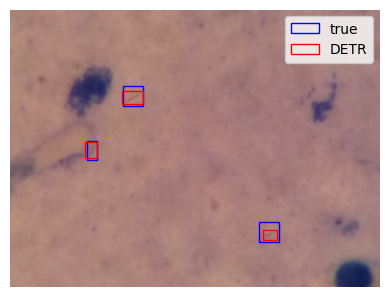

In [5]:
# see how the model performs on a single image
image = unlabeled_ds._images[0]
boxes = detr_inference([image.pil()], model,  transform=transforms, labels=False)
boxes = [Rect.from_bbox(box, bbox_format='xyxy') for box in boxes[0]]
fig, ax = plt.subplots(1, figsize=(4, 4))
image.display(color='blue', ax=ax, label='true')
for i, box in enumerate(boxes):
    box.plot(ax=ax, color='red', label='DETR' if i == 0 else None)
ax.legend()
fig.show()

In [284]:
# 3. load the dataset of images and annotations that we will use to train the loss prediction model
# i.e same images and annotations that we used to train the DETR model (train, val, test splits)
tr_dataset = TBBacilliDataset(['train', 'test', 'val'], transform=make_ds_transforms('train', includes_target=True))
args = get_args_parser().parse_args([]) # get the default arguments
criterion = build_criterion(args) # build the criterion

print(f"Found {len(tr_dataset)} labeled images")

Found 301 labeled images


In [285]:
count_annos = lambda ds: sum([len(img.rects) for img in ds._images])

print(len(tr_dataset.subset('train')), "training images", count_annos(tr_dataset.subset('train')), "annotations")
print(len(tr_dataset.subset('val')), "validation images", count_annos(tr_dataset.subset('val')), "annotations")
print(len(tr_dataset.subset('test')), "test images", count_annos(tr_dataset.subset('test')), "annotations")

202 training images 1467 annotations
40 validation images 235 annotations
66 test images 351 annotations


0.670263816217389


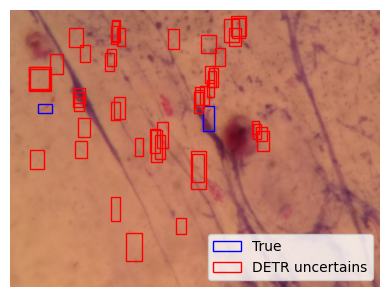

In [125]:
from bacili_detection.active_learning.uncertainty_scores import merged_area_scores
model.eval()
pred_threshold = 0.9
# get DETR class probabilities for each a single image
# ind=45
ds = tr_dataset#.subset('test')
ind = np.random.randint(0, len(ds))
# art = session.query(db.Artifact).where(db.Artifact.uri.like('%0825%')).first()
# im = ImageForObjectDetection.from_db(art)
image, target = ds[ind]
# image = transforms(im.pil())
# image = ds._images[ind]
with torch.no_grad():
    out = model([image])
# [1] is the positive class
probs = out['pred_logits'].softmax(-1)[0, :, :-1] # [N, C]
# use the threshold to filter out low confidence predictions
pred_probs = probs[probs[:, 1] > pred_threshold]
# and their corresponding boxes
pred_boxes = out['pred_boxes'][0, probs[:, 1] > pred_threshold].cpu()


# where N = number of object queries, C = number of classes
# calculate marginal probabilities
# marginal_probs = probs.mean(dim=0)
probs = torch.sort(probs, dim=1, descending=True) # sort by probability, we get [0] which is the sorted tensor while [1] is the indices
# print(probs[0].sum())
sorted_probs = probs[0]
order = probs[1]
margin_uncertainty = sorted_probs[:, 0] - sorted_probs[:, 1]
sorted_probs.shape[1]
# get the top 5 most uncertain object queries
top = margin_uncertainty.argsort()[-50:]
boxes_top = out['pred_boxes'][0, top].cpu()
# visualize the annotations and the uncertainty scores
fig, ax = plt.subplots(1, figsize=(4, 4))
ds._images[ind].display(color='blue', ax=ax, label='True', annotations=True)
boxes_ = []
for i, box in enumerate(boxes_top):
    xc, yc, w, h = box
    width, height = target['orig_size']
    box = [xc*width, yc*height, w*width, h*height]
    box = Rect.from_bbox(box, bbox_format='cxcywh')
    box.plot(ax=ax, color='red', label='DETR uncertains' if i == 0 else None)
    boxes_.append(box)

for j, box in enumerate(pred_boxes):
    xc, yc, w, h = box
    height, width,  = tr_dataset._images[0].pil().size
    box = [xc*width, yc*height, w*width, h*height]
    box = Rect.from_bbox(box, bbox_format='cxcywh')
    # box.plot(ax=ax, color='green', label='DETR prediction' if j == 0 else None)

ax.legend()

def merged_area_ratio(boxes):
    """
    Calculates the non overlapping area of a set of boxes.
    """
    # calculate the total area of the boxes
    # boxes = [box.shapely() for box in boxes]
    from shapely.geometry import box as shapely_box
    from shapely.ops import cascaded_union
    from shapely.geometry import MultiPolygon

    boxes = [shapely_box(*box.xyxy) for box in boxes]
    merged = MultiPolygon(boxes).buffer(0)
    return merged.area / sum([box.area for box in boxes])

print(merged_area_ratio(boxes_))

In [55]:
from bacili_detection.active_learning.uncertainty_scores import merged_area_scores

tr_dataset = TBBacilliDataset(['holdout:0','holdout:1','holdout:2','holdout:3'], transform=make_ds_transforms('train', includes_target=True))

dataloader = DataLoader(tr_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
area_scores = merged_area_scores(dataloader, model)

In [62]:
area_scores_ = area_scores.copy()

# create new holdouts ordered by area score
al_holdout_tag = 'al_holdout'
print(f'area_scores_ {area_scores_.shape}')
for i,holdout_tag in enumerate(['holdout:0','holdout:1','holdout:2','holdout:3']):
    holdout = tr_dataset.subset(holdout_tag)
    holdout_size = len(holdout)
    # get the top holdout_size scores from the area scores
    top_scores_inds = area_scores_.argsort()[-holdout_size:]
    # remove the top scores from the area scores
    area_scores_ = np.delete(area_scores_, top_scores_inds)
    print(f"holdout {i} has {len(top_scores_inds)} images, area_scores_ {area_scores_.shape[0]} remaining")
    # get the corresponding images
    top_scores_images = [tr_dataset._images[i] for i in top_scores_inds]
    # create a new holdout
    for im in top_scores_images:
        artifact = im.artifact
        tag = db.ArtifactTag(tag=f'{al_holdout_tag}:{i}', artifact_id=artifact.id)
        session.add(tag)
session.commit()

area_scores_ (101,)
holdout 0 has 15 images, area_scores_ 86 remaining
holdout 1 has 25 images, area_scores_ 61 remaining
holdout 2 has 35 images, area_scores_ 26 remaining
holdout 3 has 26 images, area_scores_ 0 remaining


In [64]:
len(TBBacilliDataset(['al_holdout:2'], transform=make_ds_transforms('train', includes_target=True)))

25

In [286]:
#  4. We now need to get the losses for each image in the training set to use as our target variable

# 4.1. get the losses for each image in the training set
batch_size = 2
stop_at = None # for testing purposes, stop after this many images
dataloader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
losses_dict = compute_losses(model, criterion, dataloader, device='mps', notebook=True, stop_at=1)

# save_file = f'bacili_detection/active_learning/strategies/loss_prediction/losses/detr_losses-bs{batch_size}.json'
# Path(save_file).parent.mkdir(parents=True, exist_ok=True)
# json.dump(losses_dict, open(save_file, 'w'))

  0%|          | 0/151 [00:00<?, ?it/s]

In [287]:
collate_fn

<function bacili_detection.detr.util.misc.collate_fn(batch)>

In [32]:
# check the losses
loss_files = glob.glob('bacili_detection/active_learning/strategies/loss_prediction/losses/*.json')
dfs = [pd.DataFrame.from_dict(json.load(open(f, 'r')), orient='index') for f in loss_files]
df = pd.concat(dfs, axis=0).reset_index(drop=True)
df = pd.concat([df.drop(columns=['loss_dict']), df.loss_dict.apply(pd.Series)], axis=1)\
    .assign(
        tags=lambda df: df.image_ids.apply(
            lambda l: {t.tag for i in l for t in tr_dataset._images[i].artifact.tags}),
        batch_size=lambda df: df.image_ids.apply(len)
    )
df.describe()

,loss,loss_ce,loss_bbox,loss_giou,batch_size
count,566.000000,566.000000,566.000000,566.000000,566.000000
mean,0.980244,0.150501,0.025090,0.352146,2.127208
std,0.600860,0.125643,0.043185,0.154386,1.850540
min,0.274346,0.006241,0.005421,0.096911,1.000000
25%,0.788736,0.070165,0.016947,0.297618,1.000000
50%,0.909233,0.123012,0.019642,0.337859,1.000000
75%,1.044485,0.192797,0.023037,0.374332,2.000000
max,7.432809,0.918491,0.554893,1.929533,8.000000


In [38]:
df.sort_values("loss_ce", ascending=False).head(10)

,image_ids,image_db_ids,loss,loss_ce,loss_bbox,loss_giou,tags,batch_size
279,[92],[385],5.736331,0.918491,0.312881,1.626717,{test},1
498,[134],[571],7.283216,0.870542,0.510722,1.929533,{train},1
389,[207],[881],5.735936,0.849059,0.328008,1.623418,{train},1
331,[20],[42],7.432809,0.813568,0.554893,1.922387,{test},1
366,[269],[1131],5.215224,0.774770,0.382705,1.263465,{train},1
297,[153],[640],5.164589,0.772768,0.379907,1.246143,{test},1
484,[247],[1056],4.537049,0.757418,0.285538,1.175972,{test},1
399,[203],[874],1.442909,0.650816,0.019111,0.348267,{test},1
319,[119],[511],1.699746,0.629347,0.027374,0.466765,{test},1
318,[91],[381],1.426476,0.579350,0.023319,0.365264,{train},1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Image(s) with highest loss ([92]):
Tags: {'test'}


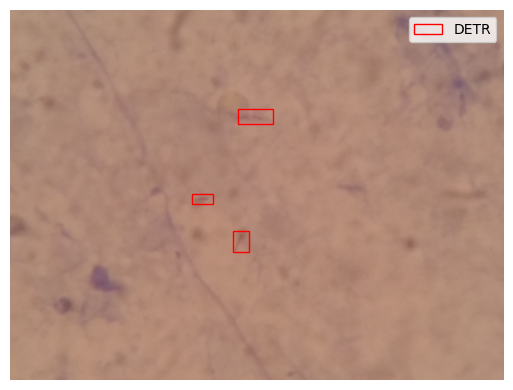

In [34]:
# which image(s) corresponds to the highest cross-entropy loss?
image_ids_highest = df.sort_values('loss_ce', ascending=False).image_ids.iloc[0]
images = [tr_dataset._images[i] for i in image_ids_highest]
fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
axes = [axes] if len(images) == 1 else axes
pred_boxes = detr_inference([im.pil() for im in images], model,  transform=transforms, labels=False)
for i, image in enumerate(images):
    image.display(color='blue', ax=axes[i], label='true')
    for j, box in enumerate(pred_boxes[i]):
        box = Rect.from_bbox(box, bbox_format='xyxy')
        box.plot(ax=axes[i], color='red', label='DETR' if j == 0 else None)
    axes[i].legend()
print(f'Image(s) with highest loss ({image_ids_highest}):')
print(f"Tags: {set([t.tag for im in images for t in im.artifact.tags])}")
fig.tight_layout()

In [ ]:
pred_boxes = detr_inference([im.pil() for im in images], model,  transform=transforms, labels=False)


The list of losses of each image is what we'll use as the target to our loss-prediction model.

### Build the features of the model

In [ ]:
# 5. build the features for each image in the training set
## What we consider as features is up to us. Here we use the following:
# - the output features from the CNN backbone of DETR (i.e. the output of the fine-tuned ResNet50)
# - the output features of the transformer encoder of DETR
# - the output features of the transformer decoder of DETR -> this is almost equivalent to full inference of DETR, so we'll try to avoid it

# 5.1. get the features from the CNN backbone of DETR

# get the features from the CNN backbone of DETR
from typing import List
from bacili_detection.detr.util.misc import nested_tensor_from_tensor_list
from bacili_detection.detr.models import detr_inference
from bacili_detection.detr.models.detr import PostProcess
from tqdm.notebook import tqdm

# get the features from the CNN backbone of DETR
def compute_features(images:List, model, transform, device='cpu'):
    sample = [transform(image) for image in images]
    sample = nested_tensor_from_tensor_list(sample)
    sample = sample.to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        features, pos = model.backbone(sample)
        src, _ = features[-1].decompose()
        src, pos = model.input_proj(src), pos[-1]
    return src, pos

In [19]:
from bacili_detection.detr.util.features import calculate_features

# check the different features that we can extract from the CNN backbone
images = [tr_dataset._images[i].pil() for i in range(10)]
feat = calculate_features(images, model, transform=transforms, device='cpu')

In [ ]:
Baci

In [40]:
import time

feat_type = ['backbone', 'encoder_memory', 'transformer', 'output']
for i, f in enumerate(feat_type):
    images = [tr_dataset._images[j].pil() for j in range(i*10, i*10+10)]
    start = time.time()
    feat = calculate_features(images, model, transform=transforms, device='mps', stop_at=f)
    feat.to('cpu', stage=f)
    print(f"Time to calculate {f} features: {time.time() - start:.2f}s")
    assert getattr(feat, f) is not None

Time to calculate backbone features: 5.51s
Time to calculate encoder_memory features: 5.38s
Time to calculate transformer features: 5.60s
Time to calculate output features: 5.24s


In [21]:
print("backbone.src:", feat.backbone['src'].size())
print("backbone.pos:", feat.backbone['pos'].size())
print("encoder_memory:", feat.encoder_memory.size())
print("transformer:", feat.transformer.size())
print("logits:", feat.output['logits'].size())
print("pred_boxes:", feat.output['boxes'].size())

backbone.src: torch.Size([10, 256, 25, 34])
backbone.pos: torch.Size([10, 256, 25, 34])
encoder_memory: torch.Size([10, 256, 25, 34])
transformer: torch.Size([10, 100, 256])
logits: torch.Size([100, 3])
pred_boxes: torch.Size([100, 4])


In [8]:
# get the features from the CNN backbone of DETR
features_size = (256, 25, 34)
features = torch.zeros((len(tr_dataset), *features_size))
positional_encodings = torch.zeros((len(tr_dataset), *features_size))
step=20 # process images in batches of {step} images
for i in tqdm(range(0, len(tr_dataset), step)):
    images = [tr_dataset._images[j].pil() for j in range(i, min(i+step, len(tr_dataset)))]
    src, pos = compute_features(images, model, transforms, device='mps')
    features[i:i+step] = src
    positional_encodings[i:i+step] = pos

In [302]:
# save as torch tensor
save_file_f = f'bacili_detection/active_learning/features/detr-bs{batch_size}_features.pt'
save_file_p = f'bacili_detection/active_learning/features/detr-bs{batch_size}_positional.pt'
Path(save_file_f).parent.mkdir(parents=True, exist_ok=True)
torch.save(features, save_file_f)
torch.save(positional_encodings, save_file_p)

In [303]:
# size of the features file
print(f"Size of features file: {Path(save_file_f).stat().st_size / 1e6:.2f} MB")
print(f"Size of positional encodings file: {Path(save_file_p).stat().st_size / 1e6:.2f} MB")

Size of features file: 261.99 MB
Size of positional encodings file: 261.99 MB


Build a DNN model that takes the input features of the model and outputs the loss of the model.

In [ ]:
from bacili_detection.active_learning.strategies.loss_prediction import DETRLossPredictor
from bacili_detection.utils.transforms import RandomSelect, AvgFeaturesTransform, RandomSampleFeaturesTransform
from bacili_detection.utils.datasets import BatchedFeaturesDataset
from torchvision import transforms as T
# 6. train the DNN

# 6.1. prepare the data

# load the features and losses
loss_files = glob.glob('bacili_detection/active_learning/strategies/loss_prediction/losses/*.json')
dfs = [pd.DataFrame.from_dict(json.load(open(f, 'r')), orient='index') for f in loss_files]
loss_df = pd.concat(dfs, axis=0).reset_index(drop=True).assign(batch_size=lambda df: df.image_ids.apply(len))
loss_df = pd.concat([loss_df.drop(columns=['loss_dict']), loss_df.loss_dict.apply(pd.Series)], axis=1)
save_file_f = f'bacili_detection/active_learning/strategies/loss_prediction/features/detr-bs1_features.pt'
features = torch.load(save_file_f)

# transformation to handle the batched losses
transform = T.Compose([
    # apply either AvgFeaturesTransform or RandomSampleFeaturesTransform randomly
    # AvgFeaturesTransform will average the features of all samples in the batch
    # RandomSampleFeaturesTransform will randomly select the features of one of the samples in the batch
    RandomSelect(AvgFeaturesTransform(), RandomSampleFeaturesTransform(), p=0.6),
    # normalize the features
    # T.Normalize(mean=features.mean(), std=features.std()),
    # get rid of the batch dimension
    lambda x: x.squeeze(0),
])

# make a dataset 
features = features.detach()
features_dict = {i : features[i] for i in range(features.size(0))}
# let's grab some images to use as test set and make sure they are not included
# in any of the batches in the training set to avoid data leakage
test_image_ids = loss_df.image_ids.explode().drop_duplicates().sample(frac=0.1, random_state=42).tolist()
y_test = loss_df[loss_df.image_ids.apply(lambda l: any(i in test_image_ids for i in l))]
y_train = loss_df[~loss_df.image_ids.apply(lambda l: any(i in test_image_ids for i in l))]
train_ds = BatchedFeaturesDataset(features_dict, y_train, ['loss','loss_ce', 'batch_size'], transform=transform)
test_ds = BatchedFeaturesDataset(features_dict, y_test, ['loss','loss_ce', 'batch_size'], transform=transform)
# dataloader = DataLoader(ds, batch_size=2, shuffle=True, collate_fn=ds.collate_fn)
# batch = next(iter(dataloader))
# batch[0].size(), {k: v for k, v in batch[1].items()}

# split into train and test sets

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import torch.nn as nn
import torch.optim as optim

# 6.2. set up the model
batch_size = 1
num_epochs = 100
stop_patience = 7 # number of epochs to wait before early stopping
lrs_patience = 3 # number of epochs to wait before reducing the learning rate
eval_every = 5 # evaluate the model every x epochs and print loss/metrics
device = "cpu"
target_loss = 'loss_ce' # the loss to predict
model_save_file = f'bacili_detection/active_learning/strategies/loss_prediction/models/detr/loss_predictor.pt'

features_size = (256, 25, 34)
model = DETRLossPredictor(input_size=features_size[0], hidden_size=20, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=lrs_patience, verbose=True, factor=0.1)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=test_ds.collate_fn)
# early stopping
best_loss = np.inf
patience_counter = 0

In [7]:
# logging and experiment tracking with wandb
import wandb
wandb.init(project="bacilli-detection" , config={
    "model": "loss-prediction:detr",
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "num_train": len(train_ds),
    "num_test": len(test_ds),
    "input_size": features_size,
    "optimizer": optimizer.__class__.__name__,
    "lr": optimizer.param_groups[0]['lr'],
    "hidden_size": model.hidden_size,
})
wandb.watch(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: simonsanvil. Use `wandb login --relogin` to force relogin


[]

In [8]:
# 6.3. train the model until convergence
from tqdm.notebook import tqdm

at_sample_seen = 0 
run_start = wandb.run.get_start_datetime()

model.to(device)

model.train()
for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    for ind, (X, target) in enumerate(train_loader):
        X = X.to(device)
        y = target[target_loss].to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        at_sample_seen += len(X)
        if ind % 10 == 0:
            wandb.log({"epoch": epoch, "tain_loss": loss.item()}, step=at_sample_seen)
    train_loss /= len(train_loader)
    if (epoch % eval_every != 0) and (epoch != num_epochs-1):
        continue
    model.eval()
    test_loss = 0
    ys, y_preds = [], []
    for X, target in test_loader:
        X = X.to(device)
        y = target[target_loss].to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        test_loss += loss.item()
        ys.append(y.cpu().detach().numpy())
        y_preds.append(y_pred.cpu().detach().numpy())
    test_loss /= len(test_loader)
    lr_scheduler.step(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}')
    r2 = r2_score(np.concatenate(ys), np.concatenate(y_preds))
    rmse = mean_squared_error(np.concatenate(ys), np.concatenate(y_preds), squared=False)
    print(f'test - R2 score: {r2:.2f} - RMSE: {rmse:.2f}')
    wandb.log({"epoch": epoch, "r2_score": r2},step=at_sample_seen)
    wandb.log({"test_loss": test_loss, "epoch": epoch, "lr": optimizer.param_groups[0]['lr']}, step=at_sample_seen)
    if test_loss < best_loss:
        best_loss = test_loss
        # save the model
        Path(model_save_file).parent.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), model_save_file)
        print(f'Saved model at epoch {epoch+1}')
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= stop_patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100: train_loss=2709.9053, test_loss=0.6912
test - R2 score: -90.86 - RMSE: 0.83
Saved model at epoch 1
Epoch 6/100: train_loss=0.7989, test_loss=0.3067
test - R2 score: -39.76 - RMSE: 0.55
Saved model at epoch 6
Epoch 11/100: train_loss=1.7237, test_loss=1.7067
test - R2 score: -225.82 - RMSE: 1.31
Epoch 16/100: train_loss=0.7926, test_loss=1.0777
test - R2 score: -142.22 - RMSE: 1.04
Epoch 21/100: train_loss=0.1793, test_loss=0.3992
test - R2 score: -52.06 - RMSE: 0.63
Epoch 26/100: train_loss=0.0495, test_loss=0.1086
test - R2 score: -13.44 - RMSE: 0.33
Saved model at epoch 26
Epoch 31/100: train_loss=0.0507, test_loss=0.0675
test - R2 score: -7.97 - RMSE: 0.26
Saved model at epoch 31
Epoch 36/100: train_loss=0.0517, test_loss=0.1231
test - R2 score: -15.35 - RMSE: 0.35
Epoch 41/100: train_loss=0.1605, test_loss=0.3570
test - R2 score: -46.45 - RMSE: 0.60
Epoch 46/100: train_loss=0.4634, test_loss=0.5876
test - R2 score: -77.09 - RMSE: 0.77
Epoch 00011: reducing learning rat

In [3]:
get_margin_uncertainty_scores

NameError: name 'y_pred' is not defined

In [ ]:
from bacili_detection.detr.util.features import calculate_features

# check the different features that we can extract from the CNN backbone
images = [tr_dataset._images[i].pil() for i in range(10)]
feat = calculate_features(images, model, transform=transforms, device='cpu')


In [9]:
# finish wandb run and show results
wandb.finish()
print(f'Best test loss: {best_loss:.4f}')


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,██████████▂▂▂▂▂▂▂▂▂▁
r2_score,▅▇▁▄▆███▇▆▇█████████
tain_loss,▄█▄▃▇▁▅▅▂▂▁▅▂▃▁▃▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▄▂█▅▃▁▁▁▂▃▂▁▁▁▁▁▁▁▁▁
epoch,99
lr,1e-05
r2_score,-4.49252
tain_loss,0.02987
test_loss,0.04133


Best test loss: 0.0082


---

In [121]:
from bacili_detection.detr.util.features import calculate_features

# predict the losses for the unlabeled images
artifacts = session.query(db.Artifact)\
    .join(db.Project)\
    .join(db.ArtifactTag, isouter=True)\
    .where(db.Project.name == "Bacilli Detection")\
    .group_by(db.Artifact.id)\
    .where(db.ArtifactTag.tag == "holdout")\
    .limit(60).all()
    # .having(func.count(db.ArtifactTag.id) == 0)\
print(f"Found {len(artifacts)} unlabeled images")

transforms = make_ds_transforms('test', includes_target=False)
unlabeled_ds = TBBacilliDataset(artifacts, transform=transforms, train=False)
# check the different features that we can extract from the CNN backbone
images = [im.pil() for im in unlabeled_ds._images]
feat = calculate_features(images, model, transform=transforms, device='mps')

Found 60 unlabeled images


NameError: name 'model' is not defined

Text(0.5, 1.0, 'Predicted vs true loss')

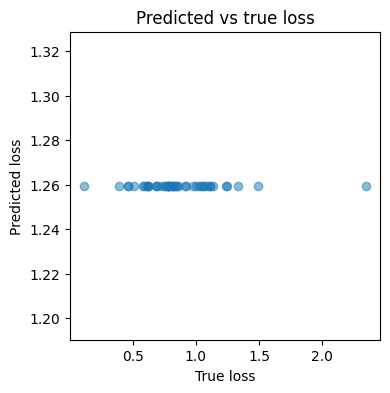

In [45]:
# 7. evaluate the model
# 7.1. get the predictions for the test set
import matplotlib.pyplot as plt
model.eval()
ys, y_preds = [], []
for X, y in test_loader:
    y_pred = model(X)
    ys.append(y.detach().numpy())
    y_preds.append(y_pred.detach().numpy())

# 7.2. plot the predictions vs the true values
fig, ax = plt.subplots(1, figsize=(4, 4))
ax.scatter(np.concatenate(ys), np.concatenate(y_preds), alpha=0.5)
ax.set_xlabel('True loss')
ax.set_ylabel('Predicted loss')
ax.set_title('Predicted vs true loss')

In [320]:
model.parameters()

<generator object Module.parameters at 0x2f00ce510>

In [311]:
X.size()

torch.Size([32, 256, 25, 34])